In [13]:
# load data
import sys
if sys.version_info[0] < 3:
    raise Exception("Python 3 not detected.")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import random

wine = io.loadmat("data.mat")
print("\nloaded %s data!" % wine)
fields = "X", "y", "X_test"
for field in fields:
    print(field, wine[field].shape)
    
wine_X = wine['X']
wine_y = wine['y']
wine_test = wine['X_test']


loaded {'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Feb 26 19:25:34 2017', '__version__': '1.0', '__globals__': [], 'y': array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]]), 'X': array([[ 5.8  ,  0.555,  0.26 , ...,  0.46 ,  9.1  ,  0.5  ],
       [ 6.3  ,  0.36 ,  0.19 , ...,  0.52 , 12.7  ,  0.6  ],
       [ 6.4  ,  0.21 ,  0.5  , ...,  0.43 ,  8.8  ,  0.5  ],
       ...,
       [ 7.3  ,  0.2  ,  0.37 , ...,  0.49 , 10.9  ,  0.6  ],
       [ 8.5  ,  0.25 ,  0.27 , ...,  0.33 , 12.   ,  0.6  ],
       [ 6.6  ,  0.36 ,  0.21 , ...,  0.41 ,  9.9  ,  0.6  ]]), 'description': array(['fixed acidity       ', 'volatile acidity    ',
       'citric acid         ', 'residual sugar      ',
       'chlorides           ', 'free sulfur dioxide ',
       'total sulfur dioxide', 'density             ',
       'pH                  ', 'sulphates           ',
       'alcohol             ', 'quality             '], dtype='<U20'), 'X_test':

In [14]:
# split data
train_label = np.concatenate((wine_X, wine_y), axis=1)
Wcolname = np.array([str(i) for i in np.arange(wine_X.shape[1] + 1)])
train_label_df = pd.DataFrame(data = train_label, columns = Wcolname)
train_label_df.sample(frac = 1)

train_label_df = np.array(train_label_df)
X_train, y_train = train_label_df[1000:,:-1],train_label_df[1000:,-1]
X_val, y_val = train_label_df[:1000,:-1],train_label_df[:1000,-1]

y_train = np.array(pd.DataFrame(y_train))

In [15]:
# normalization
X_train_n = (X_train - X_train.mean(axis = 0))/X_train.std(axis = 0)
X_val_n = (X_val - X_val.mean(axis = 0))/X_val.std(axis = 0)

In [16]:
# int type of label
y_train = np.array(pd.DataFrame(y_train)).astype(int)
y_val = np.array(pd.DataFrame(y_val)).astype(int)

### BGD

In [17]:
def BGD(X, y, a, lamb, max_iter):
    iter_cost = []
    X = np.concatenate((X,np.ones((X.shape[0],1))),axis = 1)
    w = np.random.randn(X.shape[1],1) # always be 13*1
    for i in range(max_iter):
        g = gradient(X,w,y,lamb)
        w = w - a * g  # always be 13*1
        iter_cost.append(loss(X,w,y,lamb)[0][0]) # single value
    return w,iter_cost

def gradient(X, w, y, lamb):
    return -X.T.dot(y - sigmoid(X, w)) + 2 * lamb * w # need 13 * 1

def sigmoid(X, w):
    return 1/(1 + np.exp(-X @ w)) # need to be 5000*1 

def loss(X, w, y, lamb): # single value
    return -(y.T @ np.log(sigmoid(X, w) + np.spacing(1)) + (1 - y).T @ np. log(1 - sigmoid(X, w) + np.spacing(1))) + lamb * (w.T @ w)

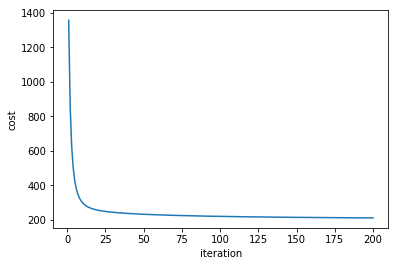

In [18]:
a = 1e-3
lamb = 1e0
max_iter = 200
w, iter_cost = BGD(X_train_n, y_train, a, lamb, max_iter);
fig = plt.figure()
plt.plot(range(1,max_iter+1), iter_cost)
plt.xlabel('iteration')
plt.ylabel('cost')
fig.savefig('BGD_loss_200iter.png')

In [19]:
# tune lambda
a = 1e-2
max_iter = 100
lambda_list= [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0, 1, 10]

In [20]:
def classifier(X_val,w):
    X_val = np.concatenate((X_val,np.ones((X_val.shape[0],1))),axis = 1)
    y_test = 1/(1+np.exp(-X_val @ w))
    y_test[y_test >= 0.5] = 1
    y_test[y_test < 0.5] =0
    y_test = y_test.astype(int)
    return y_test

In [21]:
all_accuracy = []
for i in range(len(lambda_list)):
    w, iter_cost = BGD(X_train_n, y_train, a, lambda_list[i], max_iter)
    yp = classifier(X_val_n, w)
    all_accuracy.append(sum(yp == y_val) / 1000)

([<matplotlib.axis.XTick at 0x15e27d96f98>,
 <a list of 9 Text xticklabel objects>)

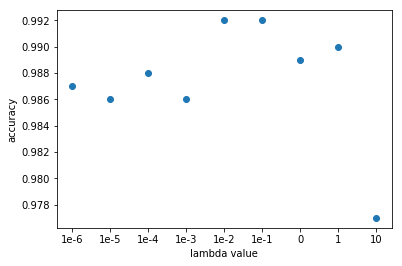

In [22]:
plt.figure()
plt.plot(range(len(lambda_list)), all_accuracy,'o')
plt.xlabel('lambda value')
plt.ylabel('accuracy')
plt.xticks(np.arange(9), ('1e-6', '1e-5', '1e-4', '1e-3', '1e-2', '1e-1', '0', '1', '10'))

### Kaggle

In [23]:
# lambda = 0
a = 1e-2
lamb = 1e0
max_iter = 5000
w, iter_cost = BGD(X_train_n, y_train, a, lamb, max_iter)
X_test_n = (wine_test - wine_test.mean(axis = 0))/wine_test.std(axis = 0)
yp = classifier(X_val_n, w)
sum(yp == y_val) / 1000
# plot(1:max_iter, iter_cost)
y_test = classifier(X_test_n, w)

In [24]:
y_test = y_test.flatten()

In [25]:
def results_to_csv(y_test):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1  # Ensures that the index starts at 1. 
    df.to_csv('submission_wine.csv', index_label='Id')
results_to_csv(y_test)